In [1]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Apr 11 06:40 kaggle.json


In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Apr 11 06:40 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls -l ~/.kaggle

total 4
-rw------- 1 root root 66 Apr 11 06:40 kaggle.json


In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia 

 99% 1.14G/1.15G [00:13<00:00, 62.3MB/s]
100% 1.15G/1.15G [00:13<00:00, 93.2MB/s]


In [6]:
from zipfile import ZipFile
print("uncompressing zip file")

filename = "chest-xray-pneumonia.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()
  
print("done")

uncompressing zip file
done


In [7]:

print("uncompressing zip file")

filename = "chest_xray.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()
  
print("done")

uncompressing zip file
done


In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, 

import os
print(os.listdir("chest_xray"))
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras import backend as k

['train', '.DS_Store', 'val', 'test']


In [26]:
imagePatches = glob('chest_xray/**/**/*.jpeg', recursive=True)
print(len(imagePatches))

17568


In [0]:
pattern_normal = '*NORMAL*'
pattern_bacteria = '*_bacteria_*'
pattern_virus = '*_virus_*'

normal = fnmatch.filter(imagePatches, pattern_normal)
bacteria = fnmatch.filter(imagePatches, pattern_bacteria)
virus = fnmatch.filter(imagePatches, pattern_virus)
x = []
y = []
for img in imagePatches:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    if img in normal:
        y.append(0)
    elif img in bacteria:
        y.append(1)
    elif img in virus:
        y.append(1)
    else:
        #break
        print('no class')
x = np.array(x)
y = np.array(y)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)
del x, y

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU 

model = Sequential()

model.add(Conv2D(32,(7,7),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(GlobalAveragePooling2D())
model.add(Dense(1000, activation='relu'))
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='pneumonia_classifier_architecture.png', show_shapes=True, show_layer_names=True)

In [0]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='pneumonia_classifier_model_checkpoint.h5',monitor="val_acc", save_best_only=True, save_weights_only=False)

In [32]:
hist = model.fit(x_train,y_train,batch_size = 32, epochs = 40, verbose=1,  validation_split=0.2, callbacks=[mcp])

Train on 11243 samples, validate on 2811 samples
Epoch 1/40
11243/11243 [==============================] - 66s 6ms/step - loss: 0.2360 - acc: 0.9048 - val_loss: 3.3045 - val_acc: 0.7367
Epoch 2/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.1739 - acc: 0.9336 - val_loss: 0.2876 - val_acc: 0.8847
Epoch 3/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.1466 - acc: 0.9454 - val_loss: 1.4509 - val_acc: 0.7367
Epoch 4/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.1319 - acc: 0.9532 - val_loss: 1.3190 - val_acc: 0.7380
Epoch 5/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.1230 - acc: 0.9538 - val_loss: 0.3568 - val_acc: 0.9109
Epoch 6/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.0932 - acc: 0.9659 - val_loss: 0.5599 - val_acc: 0.7903
Epoch 7/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.0834 - acc: 0.9695 - val_loss: 0.1003 - val_acc:

In [0]:
from keras.models import load_model
model.save('pneumonia_best_classifier_model.h5')

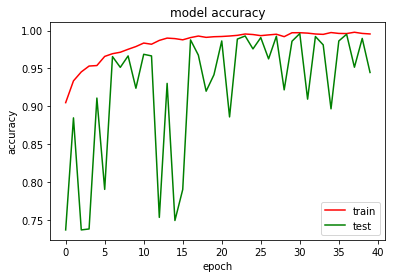

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['acc'], color='red')
ax.plot(hist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

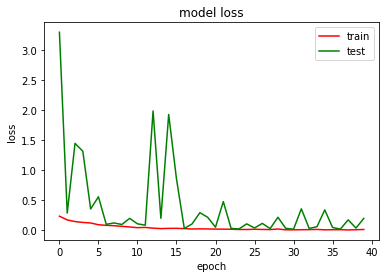

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['loss'], color='red')
ax.plot(hist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [43]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       963
           1       1.00      1.00      1.00      2551

   micro avg       1.00      1.00      1.00      3514
   macro avg       1.00      1.00      1.00      3514
weighted avg       1.00      1.00      1.00      3514



In [0]:
model.load_weights('pneumonia_classifier_model_checkpoint.h5')

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

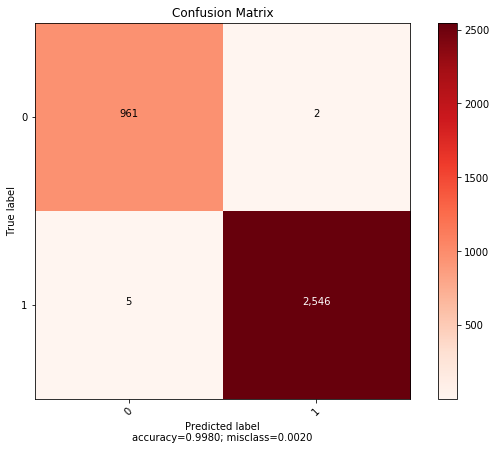

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")